# STEP 3 -  Learning for joint social influence and matching
Consider the case in which the company can observe the type of each customer Ci.
Moreover, assume that both the edge activation probabilities and reward distributions F(Dj,
Ci) are unknown. Apply jointly the greedy algorithm (for influence maximization) and the
matching algorithm using upper confidence bound in place of the edge activation
probabilities and the expected reward of each match. Apply jointly the greedy algorithm (for
influence maximization) and the matching algorithm using the TS algorithm to estimate the
edge activation probabilities and the expected reward of each match. Report the plots of the
average value and standard deviation of the cumulative regret, cumulative reward,
instantaneous regret, and instantaneous reward.

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
from scipy.optimize import linear_sum_assignment

In [11]:
class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [12]:
class Learner:
    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, [reward])
        self.t += 1

In [13]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)
    
    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            #n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)
        
    def expectations(self):
        return self.empirical_means

In [14]:
class TSLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)  # Initialize the means array with zeros

    def pull_arm(self):
        idx = np.argmax(np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1]))
        return idx
    
    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1: 
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)

    def expectations(self):
        return self.means


In [15]:
def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))

    return seeds

In [16]:
def hungarian_algorithm(matrix):
    m = -matrix.copy()  # Negate the matrix
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]


def get_reward(node_class, product_class, rewards_parameters):
    return np.random.normal(rewards_parameters[0][node_class, product_class], rewards_parameters[1][node_class, product_class])


def clairvoyant(graph_probabilities, true_prob, customer_assignments, rewards_parameters, real_reward_parameters, n_exp, seeds=None):
    hungarian_matrix = hungarian_algorithm(rewards_parameters[0])[1]

    reward_per_experiment = [[] for i in range(n_exp)]

    if seeds == None:
        opt_seeds = greedy_algorithm(graph_probabilities, 3, 50, 100)
    else:
        opt_seeds = seeds

    for e in tqdm(range(n_exp)):

        history = simulate_episode(true_prob, opt_seeds, 10)[0]
        activation_flow = np.concatenate([np.where(row == 1)[0] for row in history]).tolist()
        class_activation_flow = customer_assignments[activation_flow]
        exp_reward = 0

        units = [3, 3, 3]
        

        while units > [0, 0, 0]:

            for customer in class_activation_flow:

                # find mean of matching reward
                nonzero_index = np.nonzero(hungarian_matrix[customer])
                product_class = int(nonzero_index[0][0])

                if units[product_class] != 0:
                    reward = get_reward(customer, product_class, real_reward_parameters)
                    units[product_class] = units[product_class] - 1

                else:
                    instock_units = [index for index, value in enumerate(units) if value != 0]
                    if instock_units:  # Check if instock_units is not empty before choosing
                        product_class = random.choice(instock_units)
                        reward = get_reward(customer, product_class, real_reward_parameters)
                        units[product_class] -= 1
                    else:
                        # Handle the case when units is empty (no available units)
                        reward = 0

                exp_reward = exp_reward + reward

            reward_per_experiment[e] = exp_reward

    return np.mean(reward_per_experiment), np.std(reward_per_experiment)

In [17]:
class UCBMatching(UCBLearner):
    def __init__(self, n_arms, n_rows, n_cols):
        super().__init__(n_arms)
        self.n_rows = n_rows
        self.n_cols = n_cols
        assert n_arms == n_rows * n_cols

    def pull_arm(self):
        upper_conf = self.empirical_means + self.confidence
        upper_conf[np.isinf(upper_conf)] = 1e3
        row_ind, col_ind = linear_sum_assignment(-upper_conf.reshape(self.n_rows, self.n_cols))
        return (row_ind, col_ind)
    
    def update(self, pulled_arms, reward):
        self.t+=1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))

        for a in range(self.n_arms):
            n_samples = len(self.rewards_per_arm[a])
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        for pulled_arm, reward in zip(pulled_arms_flat, reward):
            self.update_observations(pulled_arm, reward)
            self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.t - 1) + reward) / self.t
            

    def expectations(self):
        return self.empirical_means

In [18]:
class TSMatching(TSLearner):
    def __init__(self, n_arms, n_rows, n_cols):
        super().__init__(n_arms)
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)
    
    def pull_arm(self):
        samples = np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1])
        row_ind, col_ind = linear_sum_assignment(-samples.reshape(3, 3))
        return row_ind, col_ind
    
    def update(self, pulled_arms, reward):
        self.t+=1
        pulled_arms_flat = np.ravel_multi_index(pulled_arms, (self.n_rows, self.n_cols))
        
        for pulled_arm, reward in zip(pulled_arms_flat, reward):
            self.update_observations(pulled_arm, reward)
            self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
            self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1: 
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)
                
    def expectations(self):
        return self.means

## Estimating Edge Activation Probabilities

In [19]:
n_arms = 30
edge_rate=0.03
graph_structure = np.random.binomial(1, edge_rate, (n_arms, n_arms))
graph_probabilities = np.random.uniform(0.1, 0.9, (n_arms, n_arms)) * graph_structure
graph_probabilities

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.26452106, 0.        ,
        0.        , 0.        , 0.16411639, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.40641205, 0.        ,
        0.18547864, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

### UCB Learner

In [21]:
def UCB_Generate_Probability_Estimates(p, n_arms=30, T = 365, n_experiments=10):

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        ucb_env = Environment(probabilities=p)
        # Initialize learner
        ucb_learner = UCBLearner(n_arms)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = ucb_learner.pull_arm()
            reward = ucb_env.round(pulled_arm)
            ucb_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = ucb_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round


import numpy as np

UCB_estimated_graph_probabilities = []

for index in range(len(graph_probabilities)):
    print("Estimating Arm", index)
    arm_probabilities = UCB_Generate_Probability_Estimates(graph_probabilities[index])
    arm_probabilities = np.mean(arm_probabilities, axis=0)
    UCB_estimated_graph_probabilities.append(arm_probabilities)

UCB_estimated_graph_probabilities = np.array(UCB_estimated_graph_probabilities)
UCB_estimated_graph_probabilities = np.transpose(UCB_estimated_graph_probabilities, (1, 0, 2))


for table in UCB_estimated_graph_probabilities:
    table = table*graph_structure

Estimating Arm 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.91it/s]


Estimating Arm 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.72it/s]


Estimating Arm 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.93it/s]


Estimating Arm 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.33it/s]


Estimating Arm 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.98it/s]


Estimating Arm 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.96it/s]


Estimating Arm 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.35it/s]


Estimating Arm 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00it/s]


Estimating Arm 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.18it/s]


Estimating Arm 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.00it/s]


Estimating Arm 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.38it/s]


Estimating Arm 11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.37it/s]


Estimating Arm 12


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.81it/s]


Estimating Arm 13


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.51it/s]


Estimating Arm 14


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.95it/s]


Estimating Arm 15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.06it/s]


Estimating Arm 16


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.49it/s]


Estimating Arm 17


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.61it/s]


Estimating Arm 18


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.17it/s]


Estimating Arm 19


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.07it/s]


Estimating Arm 20


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.06it/s]


Estimating Arm 21


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.91it/s]


Estimating Arm 22


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.88it/s]


Estimating Arm 23


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.81it/s]


Estimating Arm 24


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.25it/s]


Estimating Arm 25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.95it/s]


Estimating Arm 26


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.59it/s]


Estimating Arm 27


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12.34it/s]


Estimating Arm 28


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 14.30it/s]


Estimating Arm 29


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 13.52it/s]


### TS Learner

In [22]:
def TS_Generate_Probability_Estimates(p, n_arms=30, T = 365, n_experiments=10):

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        ts_env = Environment(probabilities=p)
        # Initialize learner
        ts_learner = TSLearner(n_arms)

        for t in range(0, T):
            # TS-UCB Learner
            pulled_arm = ts_learner.pull_arm()
            reward = ts_env.round(pulled_arm)
            ts_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = ts_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

import numpy as np

TS_estimated_graph_probabilities = []

for index in range(len(graph_probabilities)):
    print("Estimating Arm", index)
    arm_probabilities = TS_Generate_Probability_Estimates(graph_probabilities[index])
    arm_probabilities = np.mean(arm_probabilities, axis=0)
    TS_estimated_graph_probabilities.append(arm_probabilities)

TS_estimated_graph_probabilities = np.array(TS_estimated_graph_probabilities)
TS_estimated_graph_probabilities = np.transpose(TS_estimated_graph_probabilities, (1, 0, 2))


    
new_TS_estimated_graph_probabilities = []
for table in TS_estimated_graph_probabilities:
    cleaned_table = table*graph_structure
    new_TS_estimated_graph_probabilities.append(cleaned_table)

TS_estimated_graph_probabilities = new_TS_estimated_graph_probabilities

Estimating Arm 0


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.33it/s]


Estimating Arm 1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.65it/s]


Estimating Arm 2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.07it/s]


Estimating Arm 3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.43it/s]


Estimating Arm 4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.59it/s]


Estimating Arm 5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.84it/s]


Estimating Arm 6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.76it/s]


Estimating Arm 7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.50it/s]


Estimating Arm 8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.17it/s]


Estimating Arm 9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.17it/s]


Estimating Arm 10


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.34it/s]


Estimating Arm 11


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.33it/s]


Estimating Arm 12


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.42it/s]


Estimating Arm 13


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.51it/s]


Estimating Arm 14


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.49it/s]


Estimating Arm 15


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 30.65it/s]


Estimating Arm 16


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.96it/s]


Estimating Arm 17


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.17it/s]


Estimating Arm 18


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.90it/s]


Estimating Arm 19


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.18it/s]


Estimating Arm 20


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.24it/s]


Estimating Arm 21


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.17it/s]


Estimating Arm 22


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.01it/s]


Estimating Arm 23


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.77it/s]


Estimating Arm 24


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.36it/s]


Estimating Arm 25


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 27.10it/s]


Estimating Arm 26


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.83it/s]


Estimating Arm 27


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.87it/s]


Estimating Arm 28


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.59it/s]


Estimating Arm 29


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.58it/s]


## Estimating Matching Reward 

In [31]:
node_classes = 3
product_classes = 3
products_per_class = 3
T = 365

means = np.random.uniform(0.2, 0.8, size=(3,3))
std_dev = np.random.uniform(0.1, 0.2, size=(3, 3))
true_reward_parameters = (means, std_dev)
customer_assignments = np.random.choice([0,1,2], size=30)

### Estimating expected matching reward with UCB

In [32]:
p = true_reward_parameters[0]
n_experiments = 1
T= 365

learner = UCBMatching(p.size, *p.shape)
rewards_per_experiment = []
means_per_experiment = []
env = Environment(p)

means = []
for exp in tqdm(range(n_experiments)):
    experiment_means = []

    for t in range(T):
        pulled_arms = learner.pull_arm()
        reward = env.round(pulled_arms)
        learner.update(pulled_arms, reward)
        x = learner.expectations()
        experiment_means.append(np.array(x).reshape(3,3))
        
    means.append(experiment_means)

means = np.array(means)
ucb_means = np.mean(means, axis=0)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.57it/s]


### Estimating expected matching reward with TS

In [33]:
p = true_reward_parameters[0]
n_experiments = 1

learner = TSMatching(p.size, *p.shape)
rewards_per_experiment = []
means_per_experiment = []
env = Environment(p)

means = []
for exp in tqdm(range(n_experiments)):
    experiment_means = []

    for t in range(T):
        pulled_arms = learner.pull_arm()
        reward = env.round(pulled_arms)
        learner.update(pulled_arms, reward)
        x = learner.expectations()
        experiment_means.append(np.array(x).reshape(3,3))
        
    means.append(experiment_means)

means = np.array(means)
ts_means = np.mean(means, axis=0)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.29it/s]


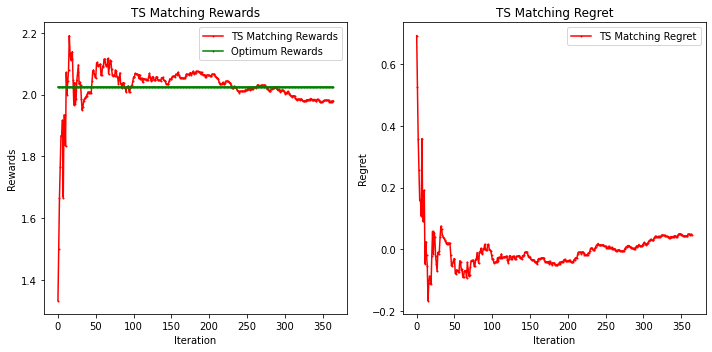

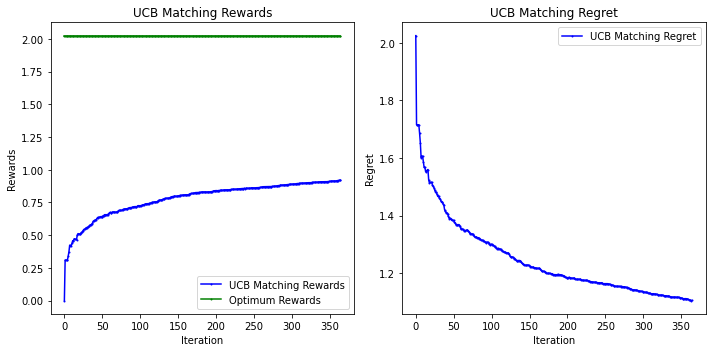

In [34]:
# to remove

row_ind, col_ind = linear_sum_assignment(-p)
optimum = p[row_ind, col_ind].sum()


ucb_matching_rewards = []
ucb_matching_regret = []

for i in range(len(ucb_means)):
    matrix = ucb_means[i]
    row_ind, col_ind = linear_sum_assignment(-matrix)
    matching_rewards_sum = matrix[row_ind, col_ind].sum()
    ucb_matching_rewards.append(matching_rewards_sum)
    ucb_matching_regret.append(optimum - matching_rewards_sum)
    

ts_matching_rewards = []
ts_matching_regret = []

for i in range(len(ts_means)):
    matrix = ts_means[i]
    row_ind, col_ind = linear_sum_assignment(-matrix)
    matching_rewards_sum = matrix[row_ind, col_ind].sum()
    ts_matching_rewards.append(matching_rewards_sum)
    ts_matching_regret.append(optimum - matching_rewards_sum)
    

    
optimums = []
for i in range(len(ucb_means)):
    optimums.append(optimum)
plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(ts_matching_rewards, marker='o', markersize=1,label='TS Matching Rewards', color="red")
plt.plot(optimums, marker='o', markersize=1,label='Optimum Rewards', color="green")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('TS Matching Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ts_matching_regret, marker='o',markersize=1, color='red', label='TS Matching Regret')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.title('TS Matching Regret')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))  
plt.subplot(1, 2, 1)
plt.plot(ucb_matching_rewards, marker='o', markersize=1,label='UCB Matching Rewards', color = "blue")
plt.plot(optimums, marker='o', markersize=1,label='Optimum Rewards', color="green")
plt.xlabel('Iteration')
plt.ylabel('Rewards')
plt.title('UCB Matching Rewards')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ucb_matching_regret, marker='o', markersize=1, color='blue', label='UCB Matching Regret')
plt.xlabel('Iteration')
plt.ylabel('Regret')
plt.title('UCB Matching Regret')
plt.legend()

plt.tight_layout()
plt.show()


## Estimating overall reward

In [36]:
std_dev = np.full(9, 0.05)
std_dev = std_dev.reshape(3,3)

import random 
T = 365
avg_ucb_overall_rew = []
avg_ts_overall_rew = []
std_dev_ucb_overall_rew = []
std_dev_ts_overall_rew = []



for index in tqdm(range(T)):
    
    ucb_round_score = clairvoyant(UCB_estimated_graph_probabilities[index], graph_probabilities, customer_assignments, (ucb_means[index],std_dev), true_reward_parameters, n_exp=3)
    avg_ucb_overall_rew.append(ucb_round_score[0])
    std_dev_ucb_overall_rew.append(ucb_round_score[1])
    
    
    ts_round_score = clairvoyant(TS_estimated_graph_probabilities[index], graph_probabilities, customer_assignments,(ts_means[index],std_dev), true_reward_parameters, n_exp=3)
    avg_ts_overall_rew.append(ts_round_score[0])
    std_dev_ts_overall_rew.append(ucb_round_score[1])


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 154.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 175.43it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 175.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 176.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 182.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 192.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 170.21it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 125.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 156.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 121.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 117.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1499.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 145.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 132.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 123.50it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 128.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 138.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 157.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 499.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 164.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.05it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2972.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 156.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 129.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.38it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 148.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.84it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1002.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 121.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 158.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 124.98it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 134.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 149.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.45it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 119.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1501.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 153.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 125.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.71it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 151.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 500.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 134.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.44it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 154.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 500.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 160.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 150.74it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 157.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 146.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.00it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.89it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 122.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 144.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.63it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 144.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 138.85it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.46it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 126.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 144.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.51it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 428.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 139.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 141.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.55it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 131.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.69it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 143.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.81it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 133.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 157.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 141.54it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 139.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.88it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 138.00it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.37it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.88it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 145.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.22it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 135.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 132.01it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 499.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 131.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.77it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 147.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.29it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 150.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 500.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 156.24it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.99it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 139.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 158.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.50it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 150.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 141.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.86it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 140.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 140.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.31it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 136.98it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 140.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 155.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.02it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 748.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 163.93it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 153.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 148.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.63it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 142.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.93it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 157.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.65it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 125.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.66it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 157.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.26it/s]

100%|███████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 599.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 149.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.33it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 155.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.44it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 141.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 152.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 138.24it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 147.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.58it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 146.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 751.89it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 156.23it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 153.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.46it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 148.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.00it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 161.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 135.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.83it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.99it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 155.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 133.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.52it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 141.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.19it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 129.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.44it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 129.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.74it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 139.52it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 128.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 143.07it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 132.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 122.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.95it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 133.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.47it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 121.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.74it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1500.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 139.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 144.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 997.61it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 131.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 131.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.46it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 124.99it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1001.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 124.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.41it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.46it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 125.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 993.60it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 129.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 120.15it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 144.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.92it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 140.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.21it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.79it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 148.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.68it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 995.09it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 121.94it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.71it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.55it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 500.06it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 149.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.89it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 140.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.21it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.78it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 159.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.98it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 600.33it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 131.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.98it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.49it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.35it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 127.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.03it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 151.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.45it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 153.84it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 128.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 140.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.16it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 144.22it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.62it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.35it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 499.80it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.52it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 119.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.49it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.61it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 150.81it/s]

100%|███████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.05it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 119.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.80it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 119.99it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 500.06it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 598.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 144.63it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.09it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.27it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.59it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 148.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.26it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 117.64it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.75it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.75it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 142.48it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 749.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 136.36it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.74it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 153.83it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.39it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 121.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 118.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.72it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 128.20it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 141.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.73it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 750.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 140.88it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.08it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 153.65it/s]

100%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 152.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.39it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.48it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 146.20it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 428.25it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 157.88it/s]

100%|███████████████████████████

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1000.07it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 143.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.48it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 142.84it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.86it/s]

100%|███████████████████████████

In [37]:
optimum_means = []
optimum_std_dev = []
attempts = []

for x in range(100):
    z = clairvoyant(graph_probabilities, graph_probabilities, customer_assignments, true_reward_parameters, true_reward_parameters, n_exp=1000)
    attempts.append(z[0])

clairvoyant_output=max(attempts)


for t in range(T):
    optimum_means.append(clairvoyant_output)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1819.53it/s]


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2216.38it/s]


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2287.88it/s]


In [38]:
optimum_means

[5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.76601142194193,
 5.766011421

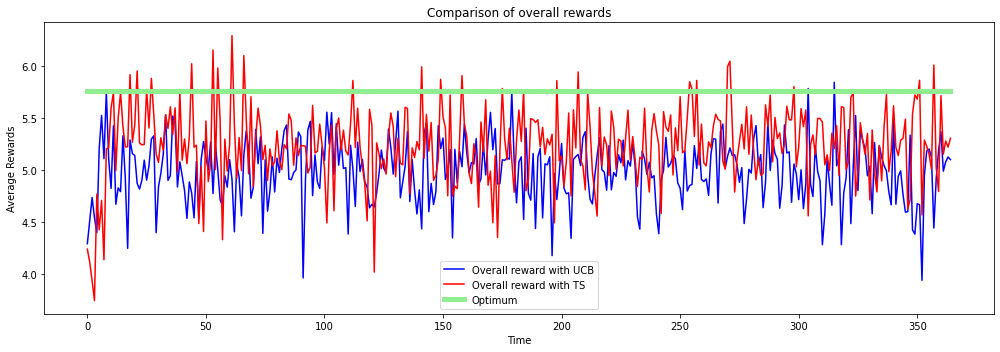

In [39]:
x = np.arange(T)

plt.figure(figsize=(14, 5))  
plt.plot(x, avg_ucb_overall_rew, label='Overall reward with UCB', color="blue")
plt.plot(x, avg_ts_overall_rew, label='Overall reward with TS', color="red")
plt.plot(x, optimum_means, label='Optimum', color="lightgreen", linewidth=5)

plt.xlabel('Time')
plt.ylabel('Average Rewards')
plt.title('Comparison of overall rewards')
plt.legend()



plt.tight_layout()
plt.show()

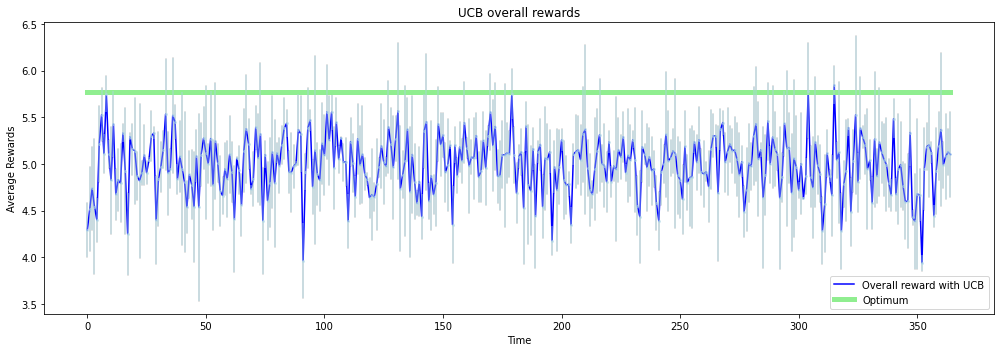

In [40]:

x = np.arange(T)

plt.figure(figsize=(14, 5))

for i in range(len(x)):
    plt.plot([x[i], x[i]], [avg_ucb_overall_rew[i] - std_dev_ucb_overall_rew[i], avg_ucb_overall_rew[i] + std_dev_ucb_overall_rew[i]], color='lightgrey')

plt.plot(x, avg_ucb_overall_rew, label='Overall reward with UCB', color="blue")
plt.plot(x, optimum_means, label='Optimum', color="lightgreen", linewidth=5)

plt.errorbar(x, avg_ucb_overall_rew, yerr=std_dev_ucb_overall_rew, fmt='o', markersize=2, color="lightblue", alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Average Rewards')
plt.title('UCB overall rewards')
plt.legend()

plt.tight_layout()
plt.show()



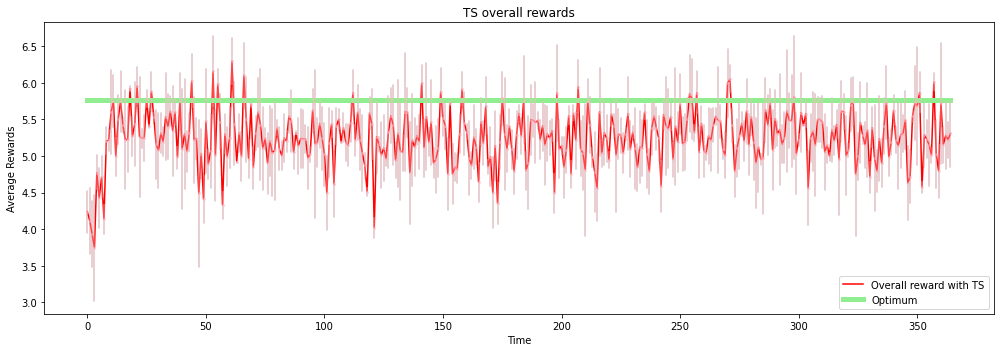

In [41]:
x = np.arange(T)

plt.figure(figsize=(14, 5))

for i in range(len(x)):
    plt.plot([x[i], x[i]], [avg_ts_overall_rew[i] - std_dev_ts_overall_rew[i], avg_ts_overall_rew[i] + std_dev_ts_overall_rew[i]], color='lightgrey')

plt.plot(x, avg_ts_overall_rew, label='Overall reward with TS', color="red")
plt.plot(x, optimum_means, label='Optimum', color="lightgreen", linewidth=5)

plt.errorbar(x, avg_ts_overall_rew, yerr=std_dev_ts_overall_rew, fmt='o', markersize=2, color="lightpink", alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Average Rewards')
plt.title('TS overall rewards')
plt.legend()

plt.tight_layout()
plt.show()

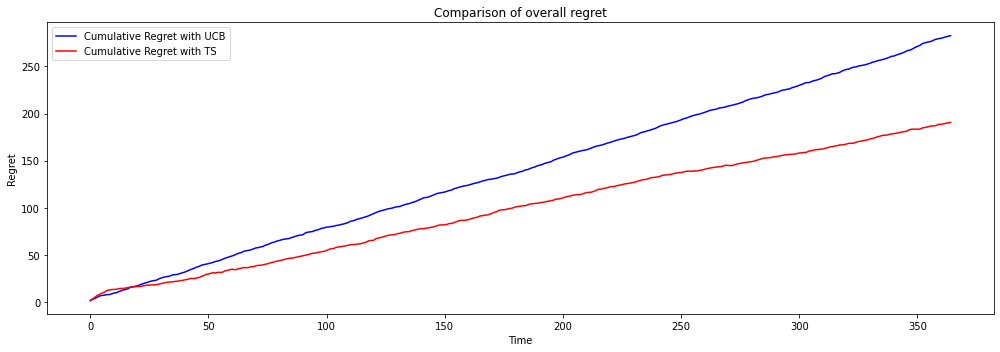

In [42]:
x = np.arange(T)

ucb_regret = np.subtract(optimum_means, avg_ucb_overall_rew)
ts_regret = np.subtract(optimum_means, avg_ts_overall_rew)
cumulative_ucb_regret = np.cumsum(ucb_regret)
cumulative_ts_regret = np.cumsum(ts_regret)


plt.figure(figsize=(14, 5))  
plt.plot(x, cumulative_ucb_regret, label='Cumulative Regret with UCB', color="blue")
plt.plot(x, cumulative_ts_regret, label='Cumulative Regret with TS', color="red")

plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('Comparison of overall regret')
plt.legend()



plt.tight_layout()
plt.show()

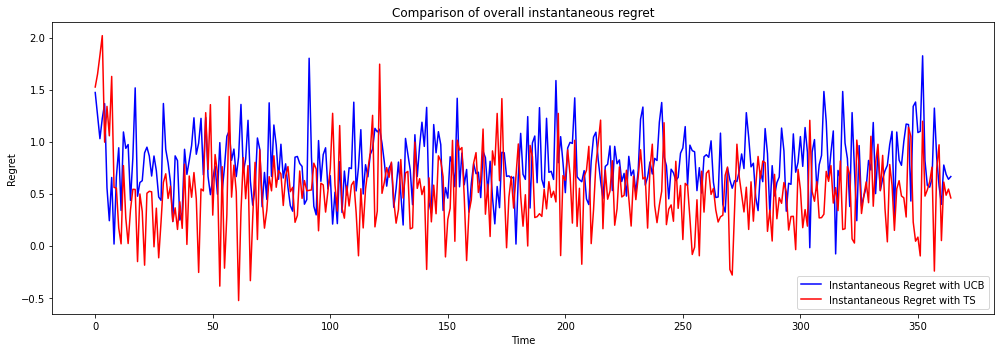

In [43]:
plt.figure(figsize=(14, 5)) 
plt.plot(x, ucb_regret, label='Instantaneous Regret with UCB', color="blue")
plt.plot(x, ts_regret, label='Instantaneous Regret with TS', color="red")

plt.xlabel('Time')
plt.ylabel('Regret')
plt.title('Comparison of overall instantaneous regret')
plt.legend()



plt.tight_layout()
plt.show()